In [1]:
import tensorflow as tf
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from time import time
%matplotlib inline

In [2]:
# Set random state

np.random.seed(20)

In [3]:
# Load the data

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)



(73257, 32, 32, 3)
(26032, 32, 32, 3)


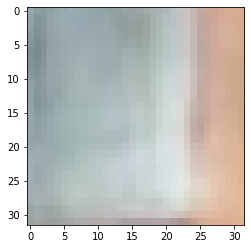

Label:  [4]


In [6]:
# Plot a random image and its label

plt.imshow(train_images[13000])
plt.show()

print('Label: ', train_labels[13000])

In [7]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [8]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [9]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [10]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [11]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [12]:
X_train = X_train[:73000,:,:,:]
y_train = y_train[:73000]

X_val = X_val[:10000,:,:,:]
y_val = y_val[:10000]

In [13]:
# Data augmentation (CNN Layer)

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [14]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(32, (5, 5), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (5, 5), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),               
    keras.layers.MaxPooling2D((2, 2)),

    
    keras.layers.Conv2D(128, (5, 5), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (5, 5), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(512, (5, 5), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/content/sample_data/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy(), 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.MeanSquaredError(),
                       tf.keras.metrics.CosineSimilarity(axis=1),
                       tf.keras.metrics.CategoricalCrossentropy()
                       ])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [16]:
# Fit model in order to make predictions
start = time()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])
end = time()
end = end - start
print('Time taken to train the data: {:.3f} seconds'.format(end))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
487/487 [==============================] - 1175s 2s/step - loss: 1.2107 - accuracy: 0.6039 - categorical_accuracy: 0.6039 - precision: 0.8429 - recall: 0.4989 - mean_squared_error: 0.0490 - cosine_similarity: 0.6665 - categorical_crossentropy: 1.2107 - val_loss: 0.6509 - val_accuracy: 0.7984 - val_categorical_accuracy: 0.7984 - val_precision: 0.8550 - val_recall: 0.7540 - val_mean_squared_error: 0.0288 - val_cosine_similarity: 0.8256 - val_categorical_crossentropy: 0.6509
Epoch 2/30
487/487 [==============================] - 1202s 2s/step - loss: 0.3901 - accuracy: 0.8832 - categorical_accuracy: 0.8832 - precision: 0.9258 - recall: 0.8536 - mean_squared_error: 0.0168 - cosine_similarity: 0.8995 - categorical_crossentropy: 0.3901 - val_loss: 0.3721 - val_accuracy: 0.8909 - val_categorical_accuracy: 0.8909 - val_precision: 0.9237 - val_recall: 0.8689 - val_mean_squared_error: 0.0159 - val_cosine_simila

In [17]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
train_cat_acc = history.history['categorical_accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_mse = history.history['mean_squared_error']
train_cos_sim = history.history['cosine_similarity']
train_categorical_entrpy = history.history['categorical_crossentropy']

val_acc = history.history['val_accuracy']
val_cat_acc = history.history['val_categorical_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_mse = history.history['val_mean_squared_error']
val_cos_sim = history.history['val_cosine_similarity']
val_categorical_entrpy = history.history['val_categorical_crossentropy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# print('Training Accuracy:', train_acc)
# print('Validation Accuracy:', val_acc)

# print('Training Loss:', train_loss)
# print('Validation Loss:', val_loss)


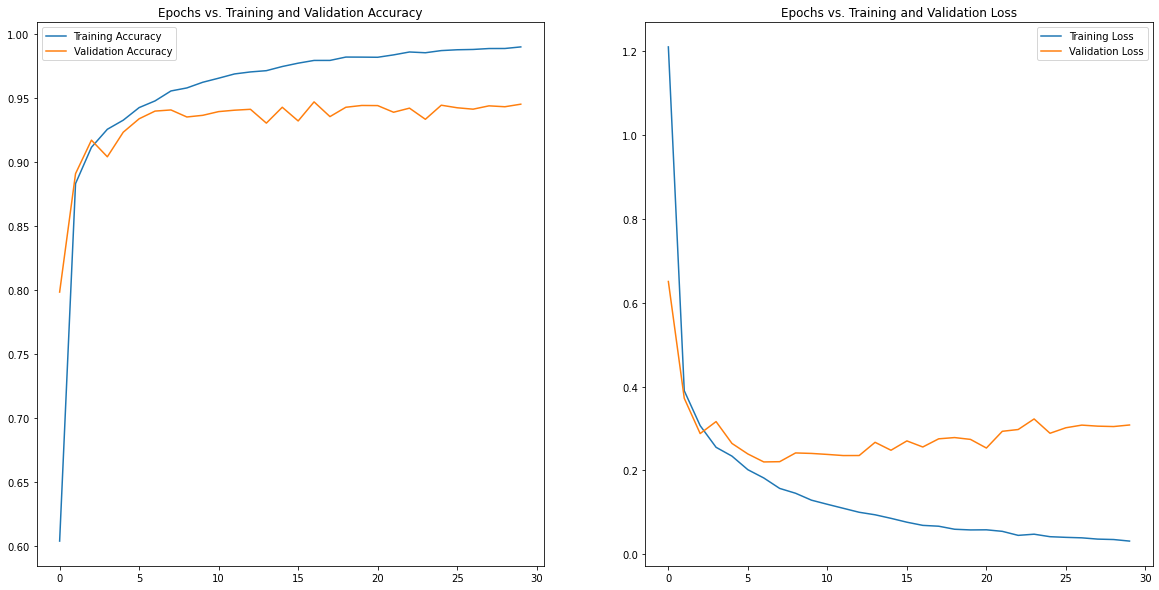

In [18]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

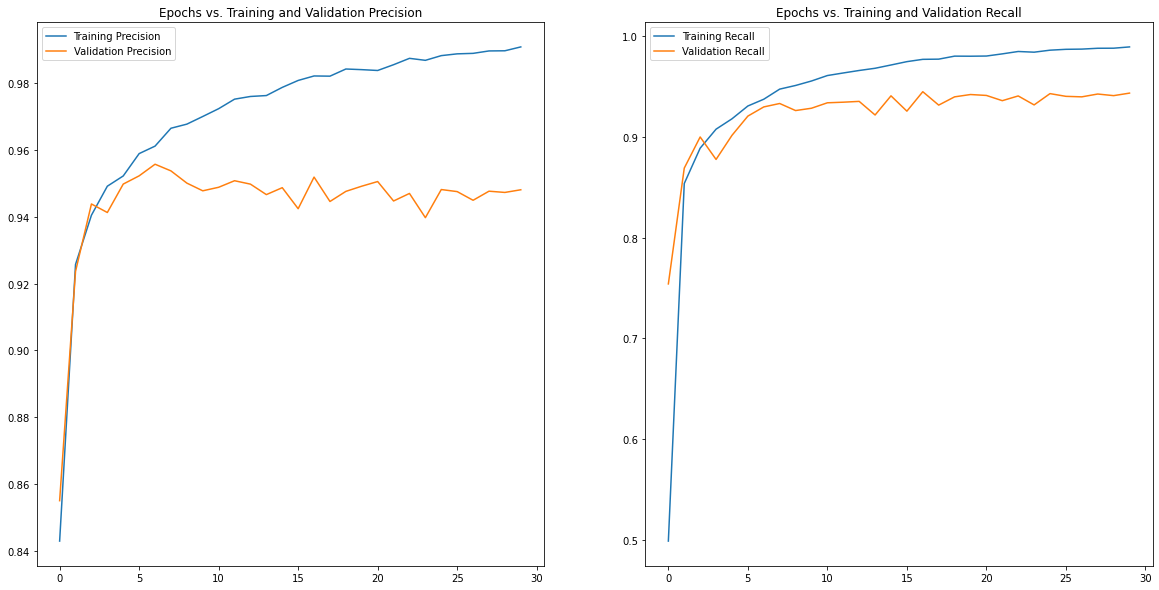

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend()
plt.title('Epochs vs. Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(train_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend()
plt.title('Epochs vs. Training and Validation Recall')

plt.show()

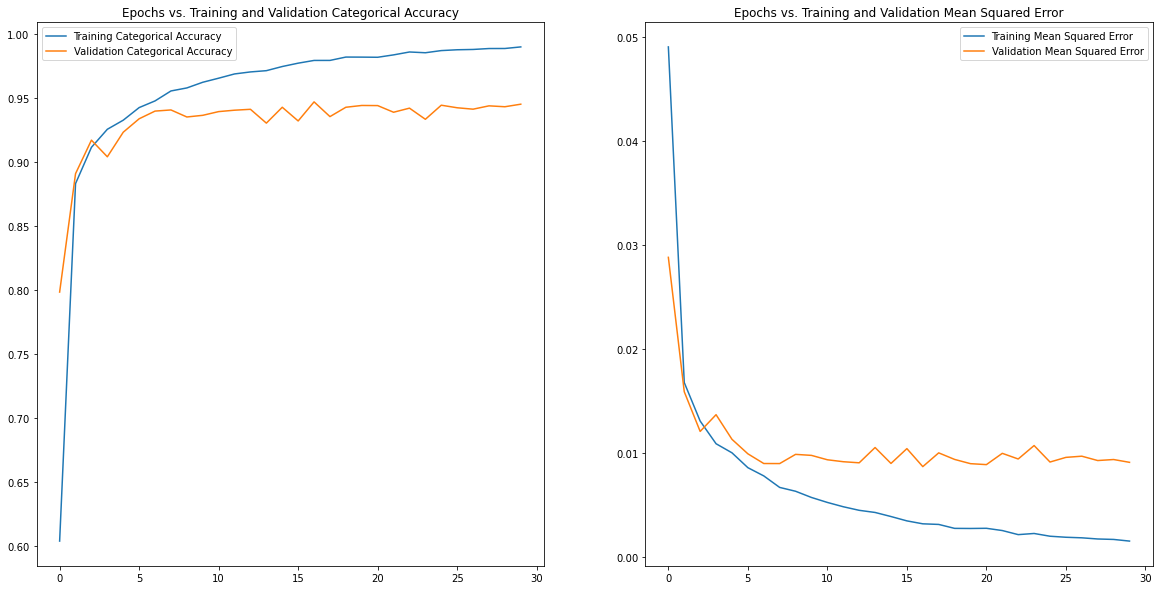

In [20]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_cat_acc, label='Training Categorical Accuracy')
plt.plot(val_cat_acc, label='Validation Categorical Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_mse, label='Training Mean Squared Error')
plt.plot(val_mse, label='Validation Mean Squared Error')
plt.legend()
plt.title('Epochs vs. Training and Validation Mean Squared Error')

plt.show()

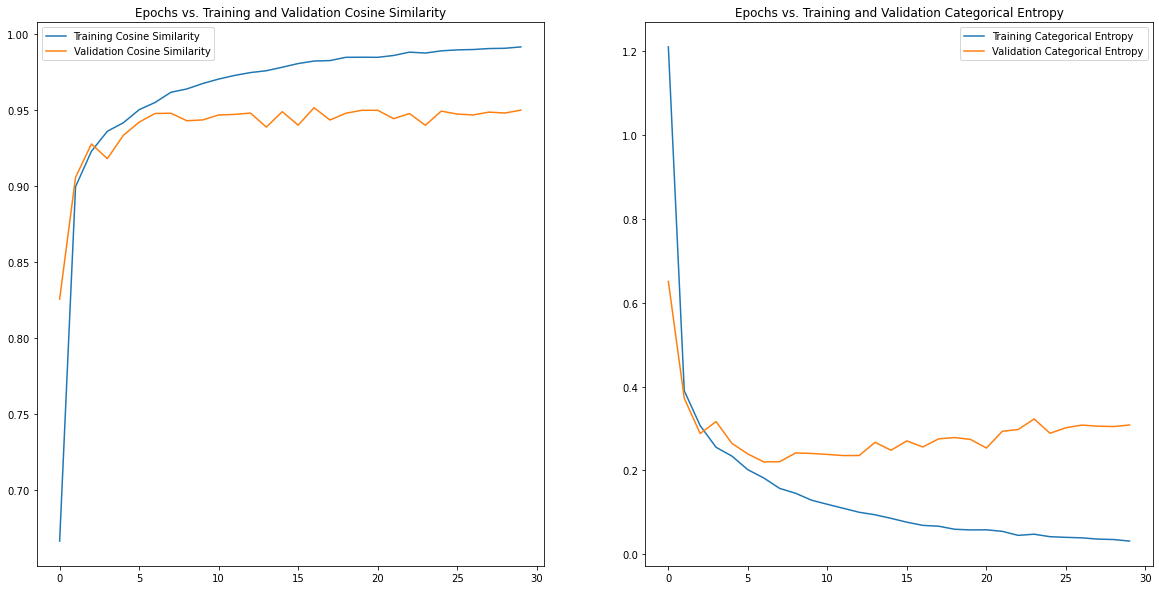

In [21]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_cos_sim, label='Training Cosine Similarity')
plt.plot(val_cos_sim, label='Validation Cosine Similarity')
plt.legend()
plt.title('Epochs vs. Training and Validation Cosine Similarity')

plt.subplot(1, 2, 2)
plt.plot(train_categorical_entrpy, label='Training Categorical Entropy')
plt.plot(val_categorical_entrpy, label='Validation Categorical Entropy')
plt.legend()
plt.title('Epochs vs. Training and Validation Categorical Entropy')

plt.show()

In [22]:
# Evaluate model on test data
test_loss, test_acc, test_cat_acc, test_precision, test_recall, test_mse, test_cos_sim, test_cat_entropy = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f} \nTest Categorical Accuracy is: {:0.4f} \nTest Precision is: {:0.4f} \nTest Recall is: {:0.4f} \nTest Mean Squared Error is: {:0.4f} \nTest Categorical Entopy is: {:0.4f}'.
      format(test_acc, test_loss, test_cat_acc, test_precision, test_recall, test_mse, test_cos_sim, test_cat_entropy))

Test accuracy is: 0.9486 
Test loss is: 0.2686 
Test Categorical Accuracy is: 0.9486 
Test Precision is: 0.9519 
Test Recall is: 0.9467 
Test Mean Squared Error is: 0.0084 
Test Categorical Entopy is: 0.9535


In [23]:
# Get predictions and apply inverse transformation to the labels (visualization and impacts)

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

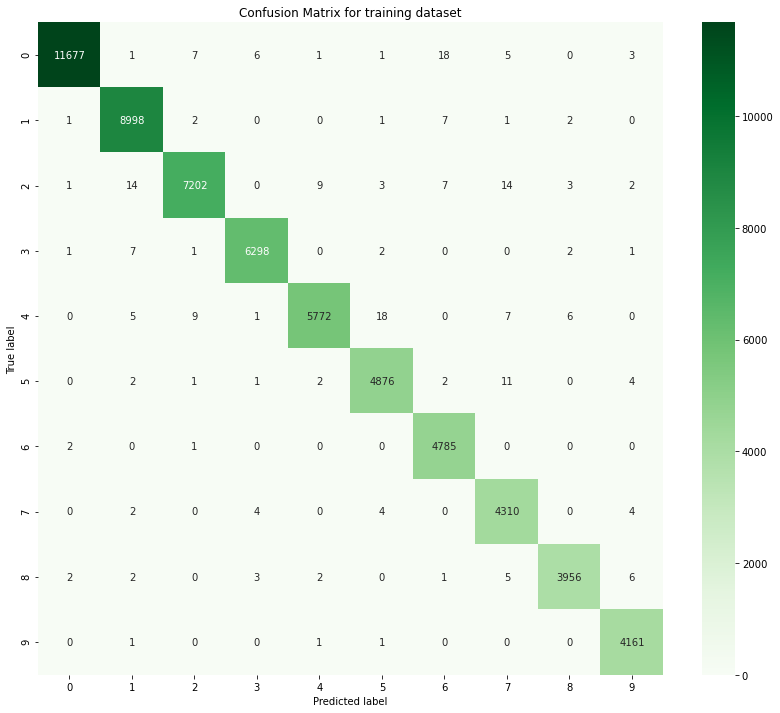

In [24]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [25]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [26]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'), 
          model.get_layer('conv2d_3'),  
          model.get_layer('conv2d_4'), 
          model.get_layer('conv2d_5'), 
]

In [27]:
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [28]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)

In [29]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

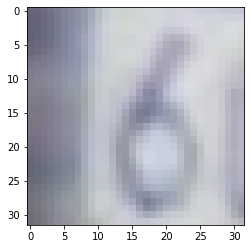

In [30]:
img = X_train[13529]
plt.imshow(img)
plt.show()

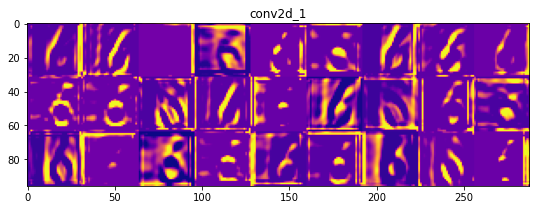

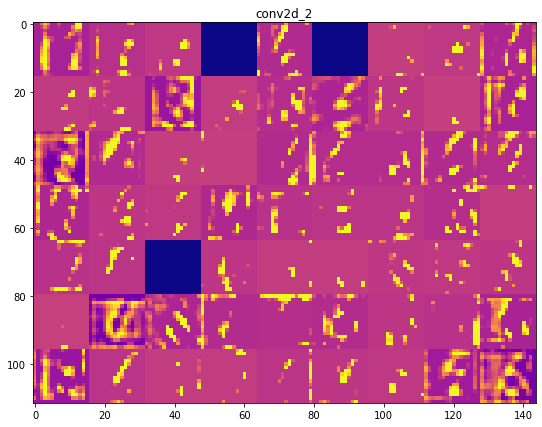

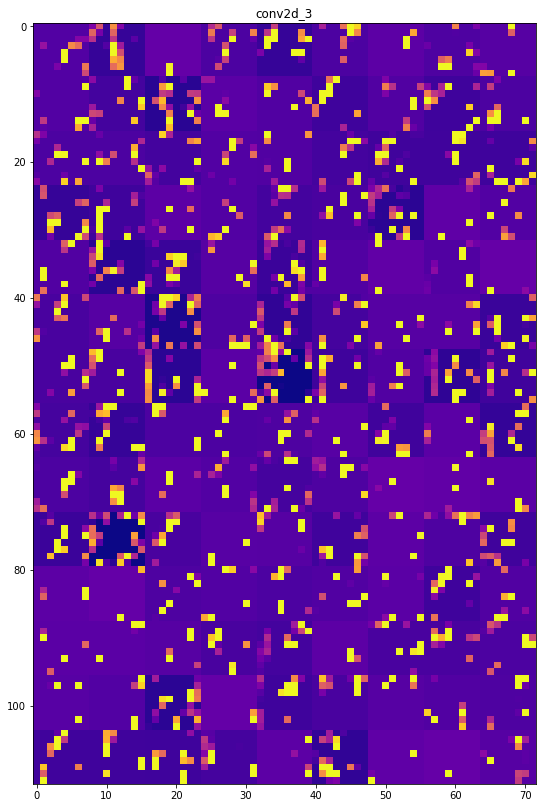

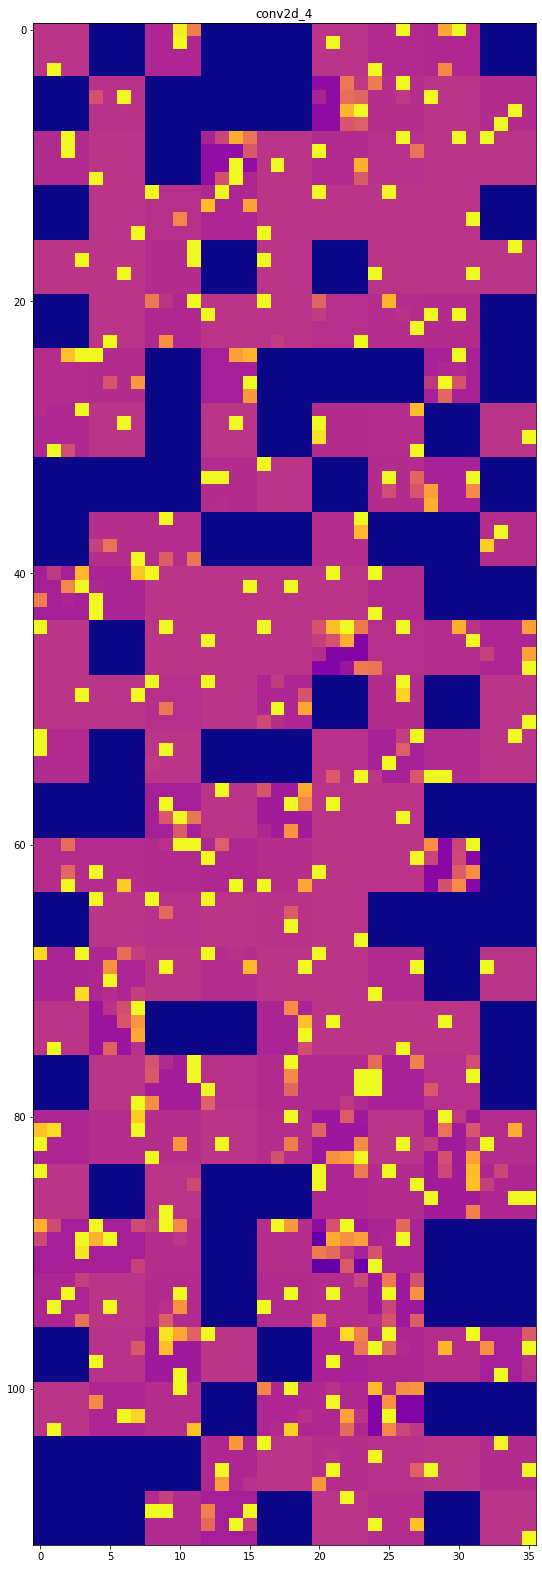

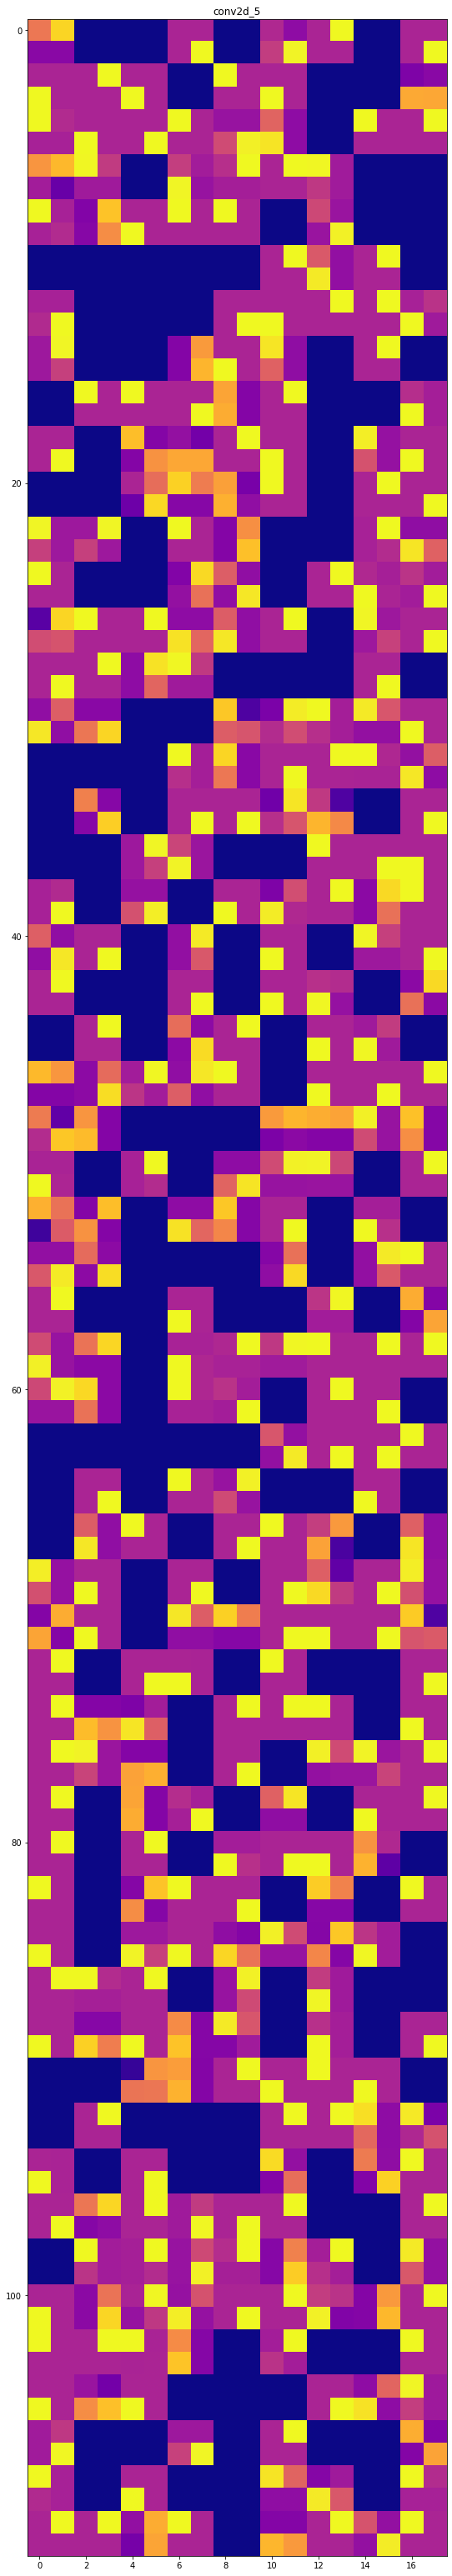

In [31]:
plot_convolutional_filters(img)